In [1]:
# load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(tidyr)))
suppressWarnings(suppressPackageStartupMessages(library(tidyverse)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
suppressWarnings(suppressPackageStartupMessages(library(ggsignif)))
# import ggplot theme
source("../../utils/figure_themes.r")

### Plot the variance and the levene test for each feature type

In [2]:
# set path to read the data
output_var_stats_path <- file.path("..","..","data","6.analysis_results","variance_results_feature_types_stats.csv")
output_var_path <- file.path("..","..","data","6.analysis_results","variance_results_feature_types.csv")
output_levene_path <- file.path("..","..","data","6.analysis_results","levene_test_results_feature_types.csv")

# read the data
variance_stats_df <- read.csv(output_var_stats_path)
variance_df <- read.csv(output_var_path)
levene_df <- read.csv(output_levene_path)
head(levene_df)
head(variance_df)
head(variance_stats_df)

,feature_group,levene_statistic,levene_p_value,group
,<chr>,<dbl>,<dbl>,<chr>
1,AreaShape,40.552751,2.315178e-10,high_area_v_unsel_area
2,AreaShape,99.061181,6.899227e-23,high_area_v_wt_area
3,AreaShape,6.977668,8.295829e-03,unsel_area_v_wt_area
4,Intensity,39.619909,4.319952e-10,high_intensity_v_unsel_intensity
5,Intensity,6.634521,1.011541e-02,high_intensity_v_wt_intensity
6,Intensity,123.711278,9.596941e-28,unsel_intensity_v_wt_intensity


,Metadata_genotype,variance,feature_group
,<chr>,<dbl>,<chr>
1,High-Severity,0.5167622,AreaShape
2,High-Severity,0.7339399,AreaShape
3,High-Severity,0.3648957,AreaShape
4,High-Severity,1.6339921,AreaShape
5,High-Severity,0.3141811,AreaShape
6,High-Severity,0.7941645,AreaShape


,Metadata_genotype,feature_group,variance_mean,variance_std,variance_max,variance_min,variance_count
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,High-Severity,AreaShape,0.4487396,0.3840812,1.6339921,4.588858e-06,28
2,High-Severity,Granularity,0.2781899,0.3579539,0.9811988,1.528730e-02,6
3,High-Severity,Intensity,0.5296292,0.2815652,1.1570140,1.290430e-01,15
4,High-Severity,Neighbors,0.7302378,0.2378980,0.9534235,4.799491e-01,3
5,High-Severity,RadialDistribution,0.7103045,0.1822159,1.0900223,4.928691e-01,12
6,Mid-Severity,AreaShape,1.0057257,0.4108429,2.2208645,5.083263e-01,28


In [3]:
# make a new column for ***
levene_df$significance <- ifelse(
    levene_df$levene_p_value < 0.001, "***", 
    ifelse(levene_df$levene_p_value < 0.01, "**", 
    ifelse(levene_df$levene_p_value < 0.05, "*", 
    "ns")
    )
)
head(levene_df)

,feature_group,levene_statistic,levene_p_value,group,significance
,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,AreaShape,40.552751,2.315178e-10,high_area_v_unsel_area,***
2,AreaShape,99.061181,6.899227e-23,high_area_v_wt_area,***
3,AreaShape,6.977668,8.295829e-03,unsel_area_v_wt_area,**
4,Intensity,39.619909,4.319952e-10,high_intensity_v_unsel_intensity,***
5,Intensity,6.634521,1.011541e-02,high_intensity_v_wt_intensity,*
6,Intensity,123.711278,9.596941e-28,unsel_intensity_v_wt_intensity,***


In [4]:
# split the levene_df into dfs for each feature group
levene_df_AreaShape <- levene_df %>% filter(feature_group == "AreaShape")
levene_df_Intensity <- levene_df %>% filter(feature_group == "Intensity")
levene_df_Granularity <- levene_df %>% filter(feature_group == "Granularity")
levene_df_Neighbors <- levene_df %>% filter(feature_group == "Neighbors")
levene_df_RadialDistribution <- levene_df %>% filter(feature_group == "RadialDistribution")

# split the variance_df into dfs for each feature group
variance_df_AreaShape <- variance_stats_df %>% filter(feature_group == "AreaShape")
variance_df_Intensity <- variance_stats_df %>% filter(feature_group == "Intensity")
variance_df_Granularity <- variance_stats_df %>% filter(feature_group == "Granularity")
variance_df_Neighbors <- variance_stats_df %>% filter(feature_group == "Neighbors")
variance_df_RadialDistribution <- variance_stats_df %>% filter(feature_group == "RadialDistribution")


## Max variance plots

In [5]:
head(variance_stats_df)
unique(variance_stats_df$Metadata_genotype)

,Metadata_genotype,feature_group,variance_mean,variance_std,variance_max,variance_min,variance_count
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,High-Severity,AreaShape,0.4487396,0.3840812,1.6339921,4.588858e-06,28
2,High-Severity,Granularity,0.2781899,0.3579539,0.9811988,1.528730e-02,6
3,High-Severity,Intensity,0.5296292,0.2815652,1.1570140,1.290430e-01,15
4,High-Severity,Neighbors,0.7302378,0.2378980,0.9534235,4.799491e-01,3
5,High-Severity,RadialDistribution,0.7103045,0.1822159,1.0900223,4.928691e-01,12
6,Mid-Severity,AreaShape,1.0057257,0.4108429,2.2208645,5.083263e-01,28


[1] "High-Severity" "Mid-Severity"  "Wild Type"

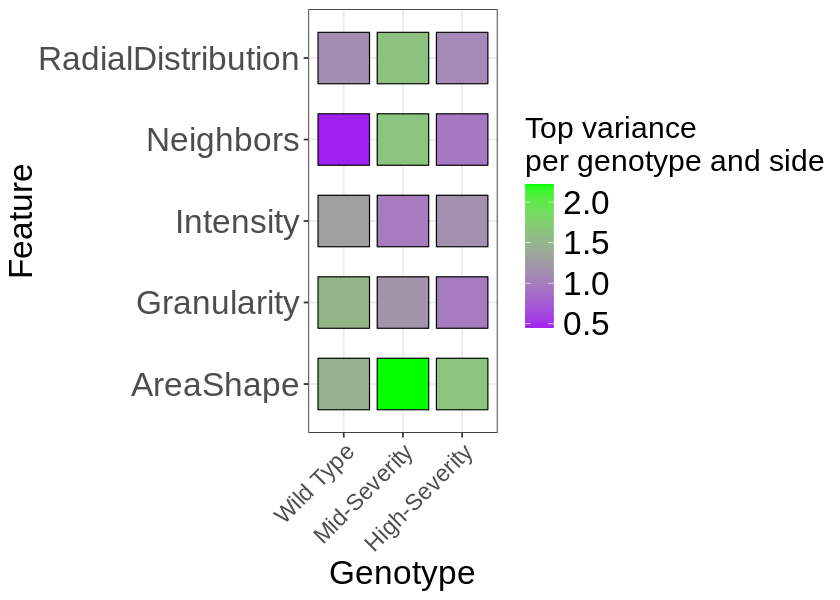

In [6]:
width <- 7
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# make genotypes and sides into factors
variance_stats_df$Metadata_genotype <- factor(variance_stats_df$Metadata_genotype, levels = c("Wild Type", "Mid-Severity", "High-Severity"))
coef_gg <- (
        ggplot(variance_stats_df, aes(x = Metadata_genotype, y = feature_group))
        + geom_point(aes(fill = abs(variance_max)), pch = 22, size = 16)
        + theme_bw()
        + scale_fill_continuous(
            name="Top variance \nper genotype and side",
            low = "purple",
            high = "green",
        )
        + xlab("Genotype")
        + ylab("Feature")
        
        + figure_theme
        + theme(
            axis.text.x = element_text(angle = 45, hjust = 1, size = 14),
        )
        # rotate x axis labels
        + theme(axis.text.x = element_text(angle = 45, hjust = 1))
        + theme(plot.title = element_text(hjust = 0.5))
        )
coef_gg
# save the plot
ggsave(file="top_variance_per_genotype.png", plot=coef_gg, path= file.path("..","figures"), dpi=600, width=width, height=height, units="in", limitsize = FALSE)

## Variance plots with levene's test

### AreaShape mean variance plot

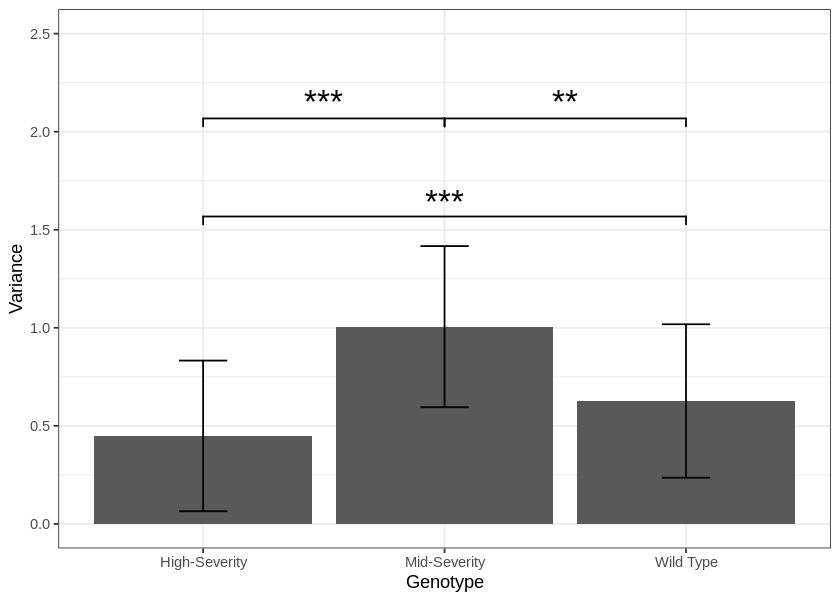

In [7]:
WT_vs_high_significance <- levene_df_AreaShape %>% filter(group == "high_area_v_wt_area")
WT_vs_unsel_significance <- levene_df_AreaShape %>% filter(group == "unsel_area_v_wt_area")
unsel_vs_high_significance <- levene_df_AreaShape %>% filter(group == "high_area_v_unsel_area")
WT_vs_high_significance <- WT_vs_high_significance$significance
WT_vs_unsel_significance <- WT_vs_unsel_significance$significance
unsel_vs_high_significance <- unsel_vs_high_significance$significance

areashape_plot <- (
        ggplot(variance_df_AreaShape, aes(x = Metadata_genotype, y = variance_mean)) 
        + geom_bar(stat = "identity")
        # add std deviation bars
        + geom_errorbar(
            aes(ymin = variance_mean - variance_std, ymax = variance_mean + variance_std),
            width = 0.2
        )
        + labs(x = "Genotype", y = "Variance", fill = "Genotype")
        + theme_bw()
        # + figure_theme
        # add significance bars
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = unsel_vs_high_significance,
            textsize = 7,
            y_position = c(2, 3)        ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unsel_significance, 
            textsize = 7,
            y_position = c(2, 3)        )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            vjust = 0.1,
            y_position = c(1.5, 2)

        )
        # remove the legend
        + theme(legend.position = "none")
        + ylim(0, 2.5)
    )
areashape_plot

### AreaShape boxplot

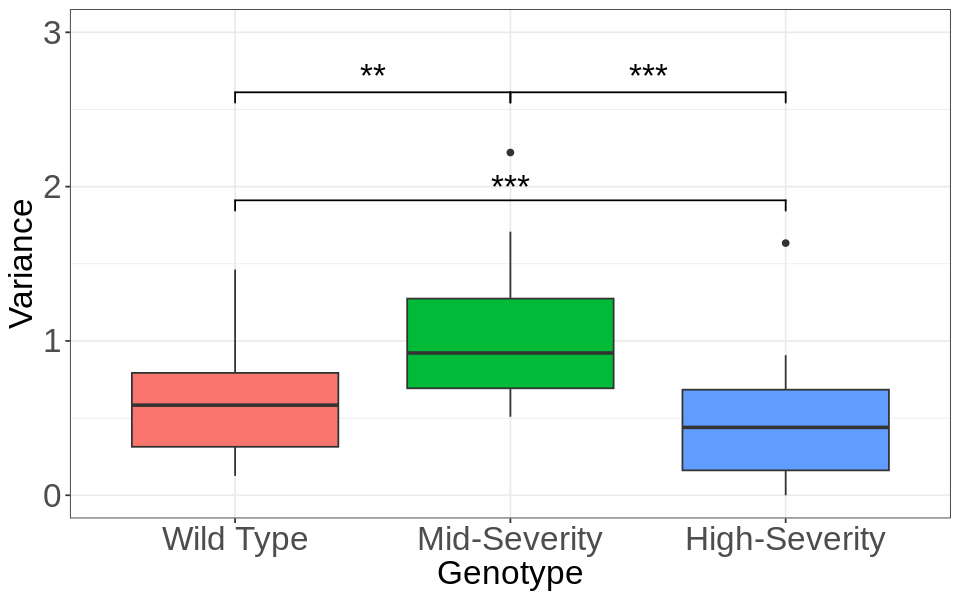

In [8]:
areashape_var <- variance_df %>% filter(feature_group == "AreaShape")
WT_vs_high_significance <- levene_df_AreaShape %>% filter(group == "high_area_v_wt_area")
WT_vs_unsel_significance <- levene_df_AreaShape %>% filter(group == "unsel_area_v_wt_area")
unsel_vs_high_significance <- levene_df_AreaShape %>% filter(group == "high_area_v_unsel_area")
WT_vs_high_significance <- WT_vs_high_significance$significance
WT_vs_unsel_significance <- WT_vs_unsel_significance$significance
unsel_vs_high_significance <- unsel_vs_high_significance$significance
# make genotype a factor
areashape_var$Metadata_genotype <- factor(areashape_var$Metadata_genotype, levels = c("Wild Type", "Mid-Severity", "High-Severity"))
width <- 8
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
areashape_plot <- (
        ggplot(areashape_var, aes(x = Metadata_genotype, y = variance)) 
        + geom_boxplot(aes(fill = Metadata_genotype))
        + labs(x = "Genotype", y = "Variance", fill = "Genotype")
        # remove the x axis label
        + theme(
            axis.title.x=element_blank(), 
            axis.ticks.x = element_blank(),
            axis.text.x = element_blank()
        )
        + theme_bw()
        + figure_theme
        # add significance bars
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = unsel_vs_high_significance,
            textsize = 7,
            y_position = c(2.5, 3)       ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unsel_significance, 
            textsize = 7,
            y_position = c(2.5, 3)        )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            vjust = 0.1,
            y_position = c(1.8, 2)

        )
        # # remove the legend
        + theme(legend.position = "none")
        + ylim(0, 3)
    )
areashape_plot
ggsave(file="variance_across_genotype_AreaShape.png", plot=areashape_plot, path= file.path("..","figures"), dpi=600, width=width, height=height, units="in", limitsize = FALSE)

## From here downward are supplementary plots

### Intensity mean variance plot

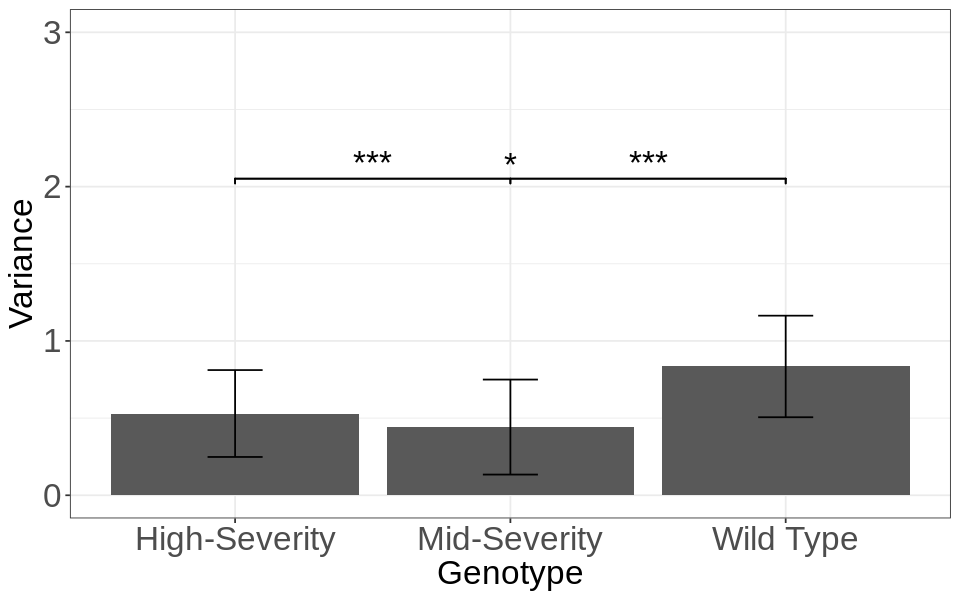

In [9]:
WT_vs_high_significance <- levene_df_Intensity %>% filter(group == "high_intensity_v_wt_intensity")
WT_vs_unsel_significance <- levene_df_Intensity %>% filter(group == "unsel_intensity_v_wt_intensity")
unsel_vs_high_significance <- levene_df_Intensity %>% filter(group == "high_intensity_v_unsel_intensity")
WT_vs_high_significance <- WT_vs_high_significance$significance
WT_vs_unsel_significance <- WT_vs_unsel_significance$significance
unsel_vs_high_significance <- unsel_vs_high_significance$significance
Intensity_plot <- (
        ggplot(variance_df_Intensity, aes(x = Metadata_genotype, y = variance_mean)) 
        + geom_bar(stat = "identity")
        + geom_errorbar(
            aes(ymin = variance_mean - variance_std, ymax = variance_mean + variance_std),
            width = 0.2
        )
        + labs(x = "Genotype", y = "Variance", fill = "Genotype")
        + theme_bw()
        + figure_theme
        # add significance bars
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = unsel_vs_high_significance,
            textsize = 7,
            y_position = c(2, 2.5),
        ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unsel_significance, 
            textsize = 7,
            y_position = c(2, 2.5),
        )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            vjust = 0.1,
            y_position = c(2, 2.5),

        )
        # remove the legend
        + theme(legend.position = "none")
        + ylim(0, 3)
    )
Intensity_plot

## Granularity mean variance plot

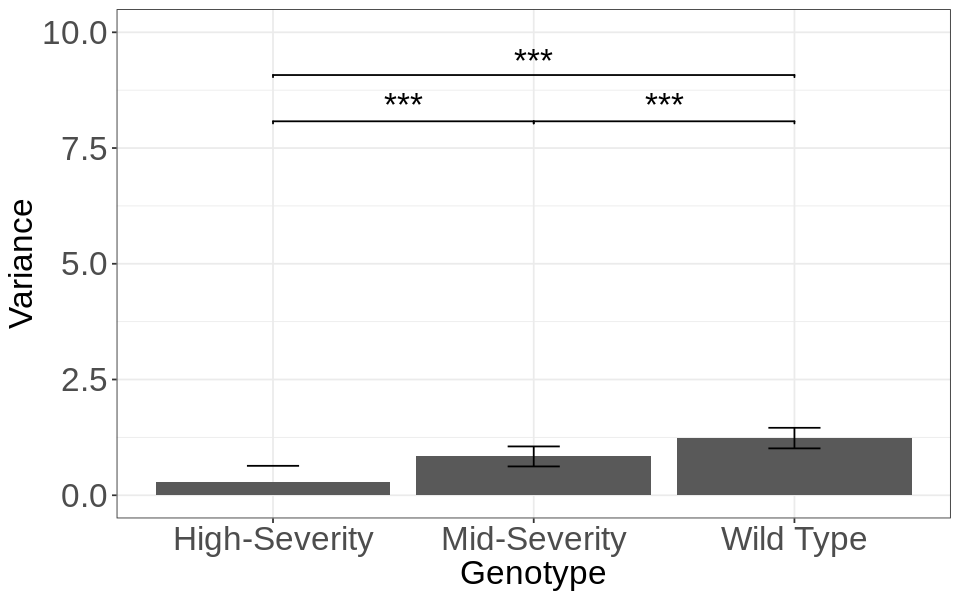

In [10]:
WT_vs_high_significance <- levene_df_Granularity%>% filter(group == "high_granularity_v_wt_granularity")
WT_vs_unsel_significance <- levene_df_Granularity %>% filter(group == "unsel_granularity_v_wt_granularity")
unsel_vs_high_significance <- levene_df_Granularity %>% filter(group == "high_granularity_v_unsel_granularity")
WT_vs_high_significance <- WT_vs_high_significance$significance
WT_vs_unsel_significance <- WT_vs_unsel_significance$significance
unsel_vs_high_significance <- unsel_vs_high_significance$significance
Granularity_plot <- (
        ggplot(variance_df_Granularity, aes(x = Metadata_genotype, y = variance_mean)) 
        + geom_bar(stat = "identity")
        + geom_errorbar(
            aes(ymin = variance_mean - variance_std, ymax = variance_mean + variance_std),
            width = 0.2
        )
        + labs(x = "Genotype", y = "Variance", fill = "Genotype")
        + theme_bw()
        + figure_theme
        # add significance bars
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = unsel_vs_high_significance,
            textsize = 7,
            y_position = c(8, 9)
        ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unsel_significance, 
            textsize = 7,
            y_position = c(8, 9),
        )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            vjust = 0.1,
            y_position = c(9, 9.5),

        )
        # remove the legend
        + theme(legend.position = "none")
        + ylim(0, 10)
    )
Granularity_plot

## Neighbors mean variance plot

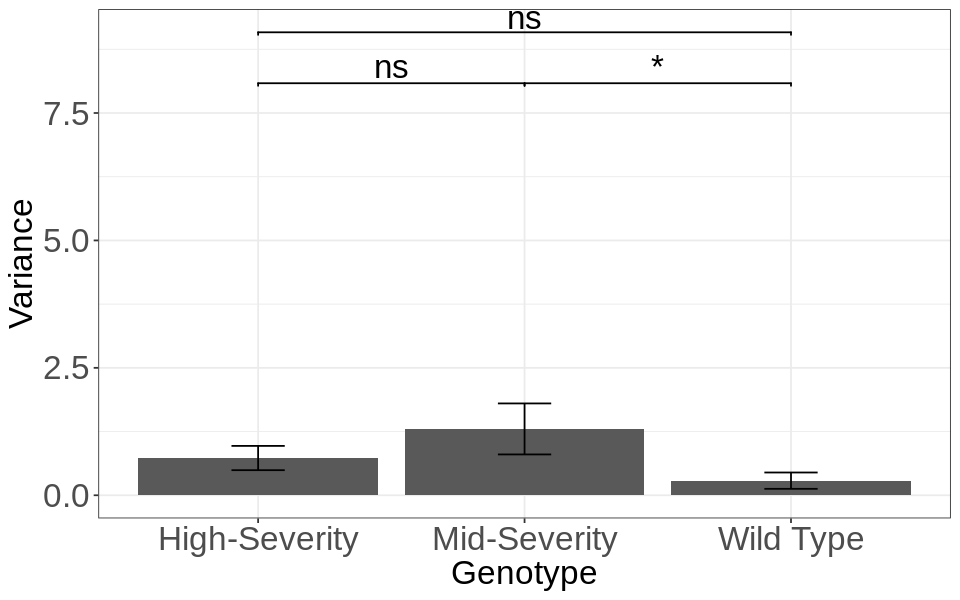

In [11]:
WT_vs_high_significance <- levene_df_Neighbors%>% filter(group == "high_neighbors_v_wt_neighbors")
WT_vs_unsel_significance <- levene_df_Neighbors %>% filter(group == "unsel_neighbors_v_wt_neighbors")
unsel_vs_high_significance <- levene_df_Neighbors%>% filter(group == "high_neighbors_v_unsel_neighbors")
WT_vs_high_significance <- WT_vs_high_significance$significance
WT_vs_unsel_significance <- WT_vs_unsel_significance$significance
unsel_vs_high_significance <- unsel_vs_high_significance$significance
neighbors_plot <- (
        ggplot(variance_df_Neighbors, aes(x = Metadata_genotype, y = variance_mean)) 
        + geom_bar(stat = "identity")
        + geom_errorbar(
            aes(ymin = variance_mean - variance_std, ymax = variance_mean + variance_std),
            width = 0.2
        )
        + labs(x = "Genotype", y = "Variance", fill = "Genotype")
        + theme_bw()
        + figure_theme
        # add significance bars
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = unsel_vs_high_significance,
            textsize = 7,
            y_position = c(8, 9)
        ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unsel_significance, 
            textsize = 7,
            y_position = c(8, 9),
        )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            vjust = 0.1,
            y_position = c(9, 9.5),

        )
        # remove the legend
        + theme(legend.position = "none")
        # + ylim(0, 10)
    )
neighbors_plot

## RadialDistribution mean variance plot

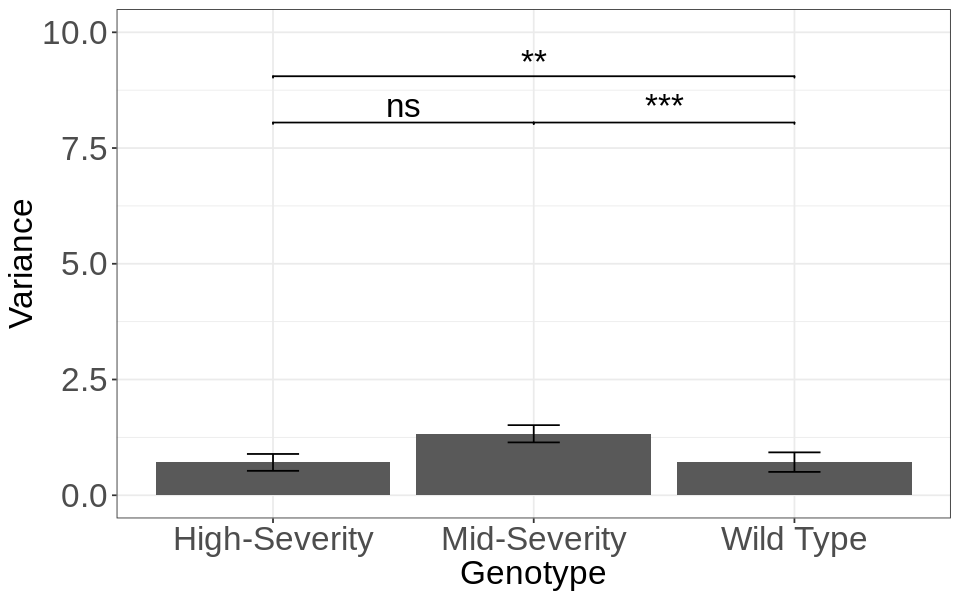

In [12]:
WT_vs_high_significance <- levene_df_RadialDistribution %>% filter(group == "high_radial_v_wt_radial")
WT_vs_unsel_significance <- levene_df_RadialDistribution %>% filter(group == "unsel_radial_v_wt_radial")
unsel_vs_high_significance <- levene_df_RadialDistribution %>% filter(group == "high_radial_v_unsel_radial")
WT_vs_high_significance <- WT_vs_high_significance$significance
WT_vs_unsel_significance <- WT_vs_unsel_significance$significance
unsel_vs_high_significance <- unsel_vs_high_significance$significance
RadialDistribution_plot <- (
        ggplot(variance_df_RadialDistribution, aes(x = Metadata_genotype, y = variance_mean)) 
        + geom_bar(stat = "identity")
        + geom_errorbar(
            aes(ymin = variance_mean - variance_std, ymax = variance_mean + variance_std),
            width = 0.2
        )
        + labs(x = "Genotype", y = "Variance", fill = "Genotype")
        + theme_bw()
        + figure_theme
        # add significance bars
        + geom_signif(
            comparisons = list(c("High-Severity","Mid-Severity")), 
            annotations = unsel_vs_high_significance,
            textsize = 7,
            y_position = c(8, 9)
        ) 
        + geom_signif(
            comparisons = list(c("Wild Type","Mid-Severity")), 
            annotations = WT_vs_unsel_significance, 
            textsize = 7,
            y_position = c(8, 9),
        )
        + geom_signif(
            comparisons = list(c("High-Severity","Wild Type")), 
            annotations = WT_vs_high_significance,
            textsize = 7,
            vjust = 0.1,
            y_position = c(9, 9.5),

        )
        # remove the legend
        + theme(legend.position = "none")
        + ylim(0, 10)
    )
RadialDistribution_plot